In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import stock_module as sm
import random
import os
import datetime
import time
import openpyxl
from sklearn.model_selection import train_test_split
import sklearn.model_selection
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
import shap

In [133]:
def short_moving_average(frame, day):
    """
    Kısa hareketli ortalama hesaplamaları için.
    """
    SMAs = []
    for i in range(frame.shape[0]):
        sma = frame[i:i+day].rolling(window=day).mean()
        sma = sma.iloc[-1,:]
        SMAs.append(sma)
    SMAs = pd.concat(SMAs, axis=1) 
    SMAs = SMAs.T
    SMAs = SMAs.dropna()
    
    return SMAs

In [134]:
def get_next_max(frame_, stock_name, start_date, end_date, next_days):
    frame = frame_.loc[frame_["stock_name"] == stock_name]
    frame = frame.loc[frame.index > start_date]
    frame = frame.loc[frame.index < end_date]
    
    next_column = []
    for i in range(frame.shape[0]):
        next_column.append(frame["StockValue"][i:next_days+i].max())
        
    frame["max"] = next_column
    frame[f"max_next_{next_days}"] = (frame["max"] - frame["StockValue"]) / frame["StockValue"]
    frame = frame.iloc[:-next_days,:]
    del frame["max"]
    
    return frame

In [135]:
def get_next_min(frame_, stock_name, start_date, end_date, next_days):
    frame = frame_.loc[frame_["stock_name"] == stock_name]
    frame = frame.loc[frame.index > start_date]
    frame = frame.loc[frame.index < end_date]
    
    next_column = []
    for i in range(frame.shape[0]):
        next_column.append(frame["StockValue"][i:next_days+i].min())
        
    frame["min"] = next_column
    frame[f"min_next_{next_days}"] = (frame["min"] - frame["StockValue"]) / frame["StockValue"]
    frame = frame.iloc[:-next_days,:]
    del frame["min"]
    
    return frame

In [136]:
frame_ = pd.read_pickle("frame_whole_BIST50")

In [137]:
start_date = "01-07-2010"
end_date = "31-07-2018"
stock_name = "BIMAS"

In [138]:
frame = frame_.loc[frame_["stock_name"] == stock_name]
frame = frame.loc[frame.index > start_date]
frame = frame.loc[frame.index < end_date]

In [139]:
# NOT: Hareketli Ortalama - MA
threshold_1 = -0.001
frame['check_1'] = frame['MA_200_CH'] > threshold_1                  
frame["check_1_value"] = (frame['MA_200_CH'] - threshold_1) * 100

threshold_2 = -0.001
frame['check_2'] = frame['MA_100_CH'] > threshold_2          
frame["check_2_value"] = (frame['MA_100_CH'] - threshold_2) * 100

threshold_3 = -0.001
frame['check_3'] = frame['MA_50_CH'] > threshold_3           
frame["check_3_value"] = (frame['MA_50_CH'] - threshold_3) * 100

threshold_4 = -0.001
frame['check_4'] = frame['MA_14_CH'] > threshold_4           
frame["check_4_value"] = (frame['MA_14_CH'] - threshold_4) * 100



threshold_5 = (frame['MA_100']*0.95)
frame['check_5'] = frame['MA_14'] > threshold_5 
frame["check_5_value"] = (frame['MA_14'] - threshold_5) / threshold_5

threshold_6 = (frame['MA_200']*0.95) 
frame['check_6'] = frame['MA_20'] > threshold_6
frame["check_6_value"] = (frame['MA_20'] - threshold_6) / threshold_6

# threshold_7 = (frame['MA_50']*1) 
# frame['check_7'] = frame['MA_7'] > threshold_7
# frame["check_7_value"] = (frame['MA_7'] - threshold_7) / threshold_7


threshold_8 = 50
frame['check_8'] = frame['RSI_5'] > threshold_8               
frame["check_8_value"] = (frame['RSI_5'] - threshold_8) / threshold_8

threshold_9 = 100
frame['check_9'] = frame["StockValue_momentum"] > threshold_9 
frame["check_9_value"] = (frame['StockValue_momentum'] - threshold_9) / threshold_9


frame['check_10'] = frame["MA_7_CH_CH"] > -3      
frame['check_11'] = frame["MA_14_CH_CH"] > -2               # -> 14 MA değerinin, 14 MA değerinin, 7 günlük trajectory
frame['check_12'] = frame["MA_50_CH_CH"] > -1              # -> 50 MA değerinin, 14 MA değerinin, 7 günlük trajectory
frame['check_13'] = frame["MA_100_CH_CH"] > -0.1           # -> 100 MA değerinin, 14 MA değerinin, 7 günlük trajectory
frame['check_14'] = frame["MA_200_CH_CH"] > -0.5           # -> 200 MA değerinin, 14 MA değerinin, 7 günlük trajectory

frame['check_15'] = frame['market_positive_ma_10'] > 0.35  # -> Markette artış gösteren hisse değerlerlerinin 10 MA değeri
frame['check_16'] = frame['RSI_5_CH'] > -0.02              # -> RSI değerinin 5 MA değeri
frame['check_17'] = frame['RSI_CH'] > -0.02                # -> RSI 7 günlük trajectory

first_check_columns = ["check_1", "check_2", "check_3", "check_4"]

second_check_columns = ["check_5", "check_6"] 

third_check_columns = ["check_8", "check_9"]

fourth_check_columns = ["check_10", "check_11", "check_12", "check_13", "check_14"]

fifth_check_columns = ["check_15", "check_16", "check_17"]

In [140]:
frame["first_check"] = frame[first_check_columns].sum(axis=1)   # sum first check categories
frame["second_check"] = frame[second_check_columns].sum(axis=1) 
frame["third_check"] = frame[third_check_columns].sum(axis=1)  
frame["fourth_check"] = frame[fourth_check_columns].sum(axis=1)  
frame["fifth_check"] = frame[fifth_check_columns].sum(axis=1)  

frame['Recommendation'] = np.where((frame["first_check"] >= 3) &
                                   (frame["second_check"]>= 2) &
                                   (frame["third_check"] >= 1) &
                                   (frame["fourth_check"] >= 4) &
                                   (frame["fifth_check"] >= 2)
                                   ,"BUY", "SELL")

In [141]:
locations = []
start = 0
for row in range(frame.shape[0]-1):
    if frame.Recommendation[row] == "BUY":
        mode = "BUY"
        if (frame.Recommendation[row] == "BUY" and frame.Recommendation[row+1] == "SELL"):
            end = row+1
            loc = [start, end]
            locations.append(loc)

    else:
        mode = "SELL"
        if (frame.Recommendation[row] == "SELL" and frame.Recommendation[row+1] == "BUY"):
            start = row+1

In [142]:
frame["MA_14_100"] = frame["MA_14"] - frame["MA_100"]
frame["MA_50_200"] = frame["MA_50"] - frame["MA_200"]
frame["MA_7_50"] = frame["MA_7"] - frame["MA_50"]

In [143]:
next_days = 100

In [144]:
frames = get_next_max(frame, stock_name, start_date, end_date, next_days)
frames = get_next_min(frames, stock_name, start_date, end_date, next_days)

In [145]:
frames['target'] = np.where((frames[f"max_next_{next_days}"] >= 0.4) 
                            & (frames[f"min_next_{next_days}"] >= -0.1)
                            ,1,0)

In [146]:
frames.target.value_counts()

0    1904
1      34
Name: target, dtype: int64

In [147]:
data = frames

In [148]:
scaling_columns = ["MA_7", "MA_14", "MA_20", "MA_50", "MA_100", 
             "MA_200",
    "Drawdown", "RSI_CH", "RSI_5_CH", "MA_7_CH", "MA_14_CH", "MA_20_CH", "MA_50_CH", "MA_100_CH", "MA_200_CH",
"volume", "volume_ma_14", "MA_14_100", "MA_50_200", "MA_7_50"]

In [149]:
data[scaling_columns] = scale(data[scaling_columns])

In [150]:
del data["stock_name"]
del data[f"max_next_{next_days}"]
del data[f"min_next_{next_days}"]
del data["StockValue"]
# del data["StockValue_momentum"]
# del data["MA_7"]
# del data["MA_14"]
# del data["MA_20"]
# del data["MA_50"]
# del data["MA_100"]
# del data["MA_200"]
# del data["Recommendation"]

In [151]:
data['marketV_to_bookV'] = data['marketV_to_bookV'].astype(float)

In [152]:
data.shape

(1938, 63)

In [153]:
data = data[["MA_7_CH", "MA_14_CH", "MA_20_CH", "MA_50_CH", "MA_100_CH", "MA_200_CH", 
             "MA_14_100", "MA_50_200","MA_7_50", "RSI_5_CH",
             "StockValue_momentum", "target", "market_positive_ma_10", "marketV_to_bookV",
             "Recommendation"]]

In [154]:
data = pd.get_dummies(data, columns = ["Recommendation"], drop_first = True)

In [155]:
# Features and Target
y = data[["target"]]
targets = y

features = data.drop("target", axis=1)
X = features

In [156]:
# Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2020, stratify=y)

In [157]:
# Translate these sets into XGBoost-compatible dense matrices
d_train = xgb.DMatrix(X_train.values, label=y_train.values, feature_names=X_train.columns)
d_validation = xgb.DMatrix(X_test, label=y_test.values, feature_names=X_test.columns)

In [158]:
# Parametrize a watch list to follow the training performance
watch_list = [(d_train, 'train'), (d_validation, 'validation')]

In [159]:
# Parameters
params = {"eta": 0.01, 
          "tree_method" : "hist",
          "grow_policy" : 'depthwise',
          "max_depth" : 6, 
          "subsample" : 0.9, 
          "colsample_bytree" : 0.9,
          "min_child_weight" : 1,
          "objective" : 'binary:hinge',
           # "base_score" : perc_def,
          "scale_pos_weight" : 1,
           # "n_estimators" : 1000, 
          "eval_metric" : "auc",
          "seed" : 13,
          "gamma" : 0.11,
          "nthread" : 14,
          "reg_alpha" : 0,
          "verbosity" : 1}

MODEL_NUMBER_OF_ROUNDS = 2000
MODEL_EARLY_STOPPING_ROUNDS = 500

In [160]:
model = xgb.train(params=params,
                        dtrain=d_train,
                        num_boost_round=MODEL_NUMBER_OF_ROUNDS,
                        evals=watch_list,
                        early_stopping_rounds=MODEL_EARLY_STOPPING_ROUNDS
)

[15:12:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.50000	validation-auc:0.50000
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 500 rounds.
[1]	train-auc:0.50000	validation-auc:0.50000
[2]	train-auc:0.50000	validation-auc:0.50000
[3]	train-auc:0.50000	validation-auc:0.50000
[4]	train-auc:0.50000	validation-auc:0.50000
[5]	train-auc:0.50000	validation-auc:0.50000
[6]	train-auc:0.50000	validation-auc:0.50000
[7]	train-auc:0.50000	validation-auc:0.50000
[8]	train-auc:0.50000	validation-auc:0.50000
[9]	train-auc:0.50000	validation-auc:0.50000
[10]	train-auc:0.50000	validat

[166]	train-auc:0.94444	validation-auc:0.78440
[167]	train-auc:0.94444	validation-auc:0.78440
[168]	train-auc:0.94444	validation-auc:0.78440
[169]	train-auc:0.94444	validation-auc:0.78440
[170]	train-auc:0.94444	validation-auc:0.78440
[171]	train-auc:0.94444	validation-auc:0.78440
[172]	train-auc:0.94444	validation-auc:0.78440
[173]	train-auc:0.94444	validation-auc:0.78440
[174]	train-auc:0.94444	validation-auc:0.78440
[175]	train-auc:0.94444	validation-auc:0.78440
[176]	train-auc:0.94444	validation-auc:0.78440
[177]	train-auc:0.94444	validation-auc:0.78440
[178]	train-auc:0.94444	validation-auc:0.78440
[179]	train-auc:0.94444	validation-auc:0.78440
[180]	train-auc:0.94444	validation-auc:0.78571
[181]	train-auc:0.94444	validation-auc:0.78571
[182]	train-auc:0.94444	validation-auc:0.78571
[183]	train-auc:0.94444	validation-auc:0.78571
[184]	train-auc:0.94444	validation-auc:0.78571
[185]	train-auc:0.94444	validation-auc:0.78571
[186]	train-auc:0.94444	validation-auc:0.78571
[187]	train-a

[341]	train-auc:1.00000	validation-auc:0.78571
[342]	train-auc:1.00000	validation-auc:0.78571
[343]	train-auc:1.00000	validation-auc:0.78571
[344]	train-auc:1.00000	validation-auc:0.78571
[345]	train-auc:1.00000	validation-auc:0.78571
[346]	train-auc:1.00000	validation-auc:0.78571
[347]	train-auc:1.00000	validation-auc:0.78571
[348]	train-auc:1.00000	validation-auc:0.78571
[349]	train-auc:1.00000	validation-auc:0.78571
[350]	train-auc:1.00000	validation-auc:0.78571
[351]	train-auc:1.00000	validation-auc:0.78571
[352]	train-auc:1.00000	validation-auc:0.78571
[353]	train-auc:1.00000	validation-auc:0.78571
[354]	train-auc:1.00000	validation-auc:0.78571
[355]	train-auc:1.00000	validation-auc:0.78571
[356]	train-auc:1.00000	validation-auc:0.78571
[357]	train-auc:1.00000	validation-auc:0.78571
[358]	train-auc:1.00000	validation-auc:0.78571
[359]	train-auc:1.00000	validation-auc:0.78571
[360]	train-auc:1.00000	validation-auc:0.78571
[361]	train-auc:1.00000	validation-auc:0.78571
[362]	train-a

[516]	train-auc:1.00000	validation-auc:0.78571
[517]	train-auc:1.00000	validation-auc:0.78571
[518]	train-auc:1.00000	validation-auc:0.78571
[519]	train-auc:1.00000	validation-auc:0.78571
[520]	train-auc:1.00000	validation-auc:0.78571
[521]	train-auc:1.00000	validation-auc:0.78571
[522]	train-auc:1.00000	validation-auc:0.78571
[523]	train-auc:1.00000	validation-auc:0.78571
[524]	train-auc:1.00000	validation-auc:0.78571
[525]	train-auc:1.00000	validation-auc:0.78571
[526]	train-auc:1.00000	validation-auc:0.78571
[527]	train-auc:1.00000	validation-auc:0.78571
[528]	train-auc:1.00000	validation-auc:0.78571
[529]	train-auc:1.00000	validation-auc:0.78571
[530]	train-auc:1.00000	validation-auc:0.78571
[531]	train-auc:1.00000	validation-auc:0.78571
[532]	train-auc:1.00000	validation-auc:0.78571
[533]	train-auc:1.00000	validation-auc:0.78571
[534]	train-auc:1.00000	validation-auc:0.78571
[535]	train-auc:1.00000	validation-auc:0.78571
[536]	train-auc:1.00000	validation-auc:0.78571
[537]	train-a

In [161]:
best_iteration = model.best_ntree_limit
print("Best iteration: " + str(best_iteration))

Best iteration: 55


In [162]:
ypred = model.predict(d_validation, ntree_limit=best_iteration)

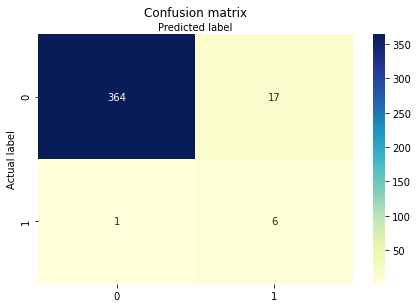

In [163]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

if params["objective"] == "binary:hinge":
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
        # create heatmap
    sn.heatmap(pd.DataFrame(confusion_matrix(y_test, ypred)), annot=True, 
                cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [164]:
fallout, sensitivity, thresholds = roc_curve(y_test, ypred)

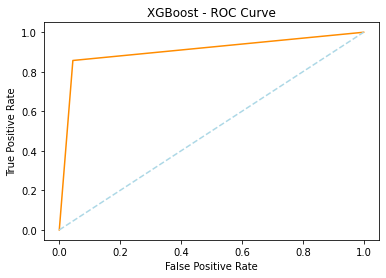

--------------------------------------------------
---------------- AUC Score: 0.906 ----------------
--------------------------------------------------


In [165]:
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color = "lightblue")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost - ROC Curve")
plt.show()

from sklearn.metrics import roc_auc_score
print(50 * "-")
print(str("-" * 16) + " AUC Score: " + str(round(roc_auc_score(y_test.values , ypred),3)) + " " + str("-" * 16))
print(50 * "-")

In [166]:
def predict(xs):
    return model.predict(xgb.DMatrix(xs))

### VALIDATION

In [167]:
BIST50 = ["TUPRS", "VAKBN","TOASO","KRDMD","MGROS","DOHOL","AKBNK","TKFEN","FROTO","GARAN","KOZAA","HALKB",
         "KORDS","TCELL","ENKAI","KOZAL","VESTL","TSKB","YKBNK","SODA","TTKOM","SKBNK","BIMAS","ODAS","PETKM",
          "SISE","ANACM", "ARCLK", "YATAS", "EREGL", "SASA", "ALARK", "SAHOL", "AEFES", "EKGYO", "THYAO",
         "HEKTS", "PGSUS", "ISCTR", "TRKCM", "KCHOL", "ISFIN", "ASELS", "TAVHL","IPEKE","ULKER","CCOLA",
         "GUBRF","AGHOL", "ENJSA"]

In [168]:
start_date = "01-07-2018"
end_date = "31-07-2020"
stock_name = stock_name

In [169]:
frame = frame_.loc[frame_["stock_name"] == stock_name]
frame = frame.loc[frame.index > start_date]
frame = frame.loc[frame.index < end_date]

In [170]:
# NOT: Hareketli Ortalama - MA
threshold_1 = -0.001
frame['check_1'] = frame['MA_200_CH'] > threshold_1                  
frame["check_1_value"] = (frame['MA_200_CH'] - threshold_1) * 100

threshold_2 = -0.001
frame['check_2'] = frame['MA_100_CH'] > threshold_2          
frame["check_2_value"] = (frame['MA_100_CH'] - threshold_2) * 100

threshold_3 = -0.001
frame['check_3'] = frame['MA_50_CH'] > threshold_3           
frame["check_3_value"] = (frame['MA_50_CH'] - threshold_3) * 100

threshold_4 = -0.001
frame['check_4'] = frame['MA_14_CH'] > threshold_4           
frame["check_4_value"] = (frame['MA_14_CH'] - threshold_4) * 100



threshold_5 = (frame['MA_100']*0.95)
frame['check_5'] = frame['MA_14'] > threshold_5 
frame["check_5_value"] = (frame['MA_14'] - threshold_5) / threshold_5

threshold_6 = (frame['MA_200']*0.95) 
frame['check_6'] = frame['MA_20'] > threshold_6
frame["check_6_value"] = (frame['MA_20'] - threshold_6) / threshold_6

# threshold_7 = (frame['MA_50']*1) 
# frame['check_7'] = frame['MA_7'] > threshold_7
# frame["check_7_value"] = (frame['MA_7'] - threshold_7) / threshold_7


threshold_8 = 50
frame['check_8'] = frame['RSI_5'] > threshold_8               
frame["check_8_value"] = (frame['RSI_5'] - threshold_8) / threshold_8

threshold_9 = 100
frame['check_9'] = frame["StockValue_momentum"] > threshold_9 
frame["check_9_value"] = (frame['StockValue_momentum'] - threshold_9) / threshold_9


frame['check_10'] = frame["MA_7_CH_CH"] > -3      
frame['check_11'] = frame["MA_14_CH_CH"] > -2               # -> 14 MA değerinin, 14 MA değerinin, 7 günlük trajectory
frame['check_12'] = frame["MA_50_CH_CH"] > -1              # -> 50 MA değerinin, 14 MA değerinin, 7 günlük trajectory
frame['check_13'] = frame["MA_100_CH_CH"] > -0.1           # -> 100 MA değerinin, 14 MA değerinin, 7 günlük trajectory
frame['check_14'] = frame["MA_200_CH_CH"] > -0.5           # -> 200 MA değerinin, 14 MA değerinin, 7 günlük trajectory

frame['check_15'] = frame['market_positive_ma_10'] > 0.35  # -> Markette artış gösteren hisse değerlerlerinin 10 MA değeri
frame['check_16'] = frame['RSI_5_CH'] > -0.02              # -> RSI değerinin 5 MA değeri
frame['check_17'] = frame['RSI_CH'] > -0.02                # -> RSI 7 günlük trajectory

first_check_columns = ["check_1", "check_2", "check_3", "check_4"]

second_check_columns = ["check_5", "check_6"] 

third_check_columns = ["check_8", "check_9"]

fourth_check_columns = ["check_10", "check_11", "check_12", "check_13", "check_14"]

fifth_check_columns = ["check_15", "check_16", "check_17"]

In [171]:
frame["first_check"] = frame[first_check_columns].sum(axis=1)   # sum first check categories
frame["second_check"] = frame[second_check_columns].sum(axis=1) 
frame["third_check"] = frame[third_check_columns].sum(axis=1)  
frame["fourth_check"] = frame[fourth_check_columns].sum(axis=1)  
frame["fifth_check"] = frame[fifth_check_columns].sum(axis=1)  

frame['Recommendation'] = np.where((frame["first_check"] >= 3) &
                                   (frame["second_check"]>= 2) &
                                   (frame["third_check"] >= 1) &
                                   (frame["fourth_check"] >= 4) &
                                   (frame["fifth_check"] >= 2)
                                   ,"BUY", "SELL")

In [172]:
locations = []
start = 0
for row in range(frame.shape[0]-1):
    if frame.Recommendation[row] == "BUY":
        mode = "BUY"
        if (frame.Recommendation[row] == "BUY" and frame.Recommendation[row+1] == "SELL"):
            end = row+1
            loc = [start, end]
            locations.append(loc)

    else:
        mode = "SELL"
        if (frame.Recommendation[row] == "SELL" and frame.Recommendation[row+1] == "BUY"):
            start = row+1

In [173]:
frame["MA_14_100"] = frame["MA_14"] - frame["MA_100"]
frame["MA_50_200"] = frame["MA_50"] - frame["MA_200"]
frame["MA_7_50"] = frame["MA_7"] - frame["MA_50"]

In [174]:
frames = get_next_max(frame, stock_name, start_date, end_date, next_days)
frames = get_next_min(frames, stock_name, start_date, end_date, next_days)

In [175]:
data = frames

In [176]:
scaling_columns = ["MA_7", "MA_14", "MA_20", "MA_50", "MA_100", 
             "MA_200",
    "Drawdown", "RSI_CH", "RSI_5_CH", "MA_7_CH", "MA_14_CH", "MA_20_CH", "MA_50_CH", "MA_100_CH", "MA_200_CH",
"volume", "volume_ma_14", "MA_14_100", "MA_50_200", "MA_7_50"]

In [177]:
data[scaling_columns] = scale(data[scaling_columns])

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.


In [178]:
max_next = data[f"max_next_{next_days}"]
min_next = data[f"min_next_{next_days}"]

In [179]:
data['target'] = np.where((data[f"max_next_{next_days}"] >= 0.07) 
                            & (data[f"min_next_{next_days}"] >= -0.1)
                            ,1,0)

In [180]:
target = data["target"]

In [181]:
del data["stock_name"]
del data[f"max_next_{next_days}"]
del data[f"min_next_{next_days}"]
del data["StockValue"]
# del data["StockValue_momentum"]
# del data["MA_7"]
# del data["MA_14"]
# del data["MA_20"]
# del data["MA_50"]
# del data["MA_100"]
# del data["MA_200"]
# del data["Recommendation"]

In [182]:
data['marketV_to_bookV'] = data['marketV_to_bookV'].astype(float)

In [183]:
data = data[["MA_7_CH", "MA_14_CH", "MA_20_CH", "MA_50_CH", "MA_100_CH", "MA_200_CH", 
             "MA_14_100", "MA_50_200","MA_7_50", "RSI_5_CH",
             "StockValue_momentum", "market_positive_ma_10", "marketV_to_bookV",
             "Recommendation"]]

In [184]:
data = pd.get_dummies(data, columns = ["Recommendation"], drop_first = True)

In [185]:
prediction = predict(data)

In [186]:
data["prediction"] = prediction

In [187]:
data[f"max_next_{next_days}"] = max_next
data[f"min_next_{next_days}"] = min_next

In [188]:
data["net"] = data[f"max_next_{next_days}"] - abs(data[f"min_next_{next_days}"])

In [189]:
data.shape

(413, 18)

In [196]:
data.loc[data.prediction==1].head(20)

,MA_7_CH,MA_14_CH,MA_20_CH,MA_50_CH,MA_100_CH,MA_200_CH,MA_14_100,MA_50_200,MA_7_50,RSI_5_CH,StockValue_momentum,market_positive_ma_10,marketV_to_bookV,Recommendation_SELL,prediction,max_next_100,min_next_100,net
2018-01-08,0.563949,0.743045,0.561285,-0.032979,0.626748,1.748515,-0.002488,0.903562,0.016300,0.043908,101.468819,0.612581,7.800722,0,1.0,0.021711,-0.107894,-0.086184
2018-01-09,0.458815,0.712437,0.624602,-0.071801,0.624093,1.717950,0.002045,0.881873,-0.031965,-0.214317,101.735624,0.573392,7.821250,0,1.0,0.019031,-0.110234,-0.091203
2018-01-10,0.344659,0.722550,0.656817,-0.079589,0.625418,1.699296,0.017021,0.860851,-0.096101,-0.312819,102.841900,0.552712,7.800722,0,1.0,0.021711,-0.107894,-0.086184
2018-01-11,0.100478,0.617481,0.635781,-0.135337,0.571451,1.673104,-0.003746,0.829898,-0.211675,-0.425716,98.119374,0.581265,7.764798,0,1.0,0.026438,-0.103767,-0.077329
2018-01-12,-0.037336,0.526209,0.590288,-0.179345,0.528026,1.666409,-0.017033,0.798222,-0.252472,-0.525259,98.885199,0.559143,7.739138,0,1.0,0.029843,-0.104775,-0.074932
2018-01-15,-0.107422,0.399965,0.528414,-0.228121,0.483804,1.646798,-0.037622,0.768821,-0.241882,-0.691348,98.188736,0.514464,7.790458,1,1.0,0.023058,-0.119236,-0.096178
2018-01-16,-0.235756,0.251917,0.465605,-0.282099,0.420450,1.614787,-0.064282,0.738520,-0.243511,-0.857477,97.441037,0.514642,7.816118,1,1.0,0.019698,-0.131475,-0.111777
2018-01-17,-0.276992,0.156824,0.420216,-0.320046,0.388242,1.607807,-0.070196,0.704628,-0.193000,-0.994847,100.000000,0.550550,7.908496,1,1.0,0.007789,-0.141619,-0.133830
2018-01-18,-0.344156,0.059115,0.384511,-0.380561,0.343141,1.596356,-0.079585,0.669686,-0.139743,-0.962657,99.357316,0.539506,7.934156,1,1.0,0.004528,-0.144396,-0.139868
2018-01-19,-0.509823,-0.099255,0.288587,-0.431285,0.269766,1.565700,-0.108342,0.636660,-0.130661,-1.078484,96.990959,0.475471,7.775062,1,1.0,0.025084,-0.126888,-0.101804


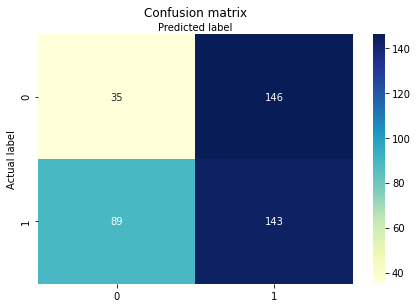

In [195]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

if params["objective"] == "binary:hinge":
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
        # create heatmap
    sn.heatmap(pd.DataFrame(confusion_matrix(target, prediction)), annot=True, 
                cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

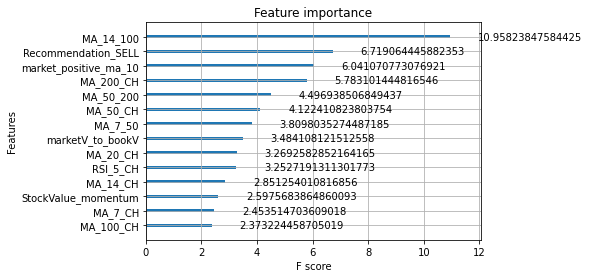

In [192]:
xgb.plot_importance(model, importance_type = "gain")

In [1124]:
data

,MA_7,MA_14,MA_20,MA_50,MA_100,MA_200,MA_14_100,MA_50_200,MA_7_50,RSI_5_CH,StockValue_momentum,market_positive_ma_10,marketV_to_bookV,Recommendation_SELL,prediction,max_next_20,min_next_20,net
2018-01-08,-0.718655,-0.754964,-0.807160,-0.789083,-0.842062,-1.463866,-0.093146,0.756897,0.025199,0.052681,101.468819,0.612581,7.800722,0,1.0,0.017105,-0.026316,-0.009211
2018-01-09,-0.737661,-0.747133,-0.793306,-0.790397,-0.835494,-1.451758,-0.088394,0.733589,-0.026864,-0.201030,101.735624,0.573392,7.821250,0,1.0,0.014438,-0.028870,-0.014432
2018-01-10,-0.762603,-0.734482,-0.787763,-0.791803,-0.829473,-1.440192,-0.072694,0.710996,-0.096049,-0.297811,102.841900,0.552712,7.800722,0,1.0,0.017105,-0.048027,-0.030922
2018-01-11,-0.811301,-0.743217,-0.782434,-0.798408,-0.827376,-1.428999,-0.094465,0.677731,-0.220719,-0.408735,98.119374,0.581265,7.764798,0,1.0,0.021811,-0.048249,-0.026438
2018-01-12,-0.832680,-0.748337,-0.783073,-0.805284,-0.825479,-1.417697,-0.108393,0.643688,-0.264727,-0.506538,98.885199,0.559143,7.739138,0,1.0,0.025201,-0.045092,-0.019891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-13,1.629877,1.691954,1.701704,1.683185,1.719645,2.103655,0.501520,0.106470,0.229819,-0.408291,96.807512,0.646371,6.690170,1,0.0,0.098933,-0.023278,0.075655
2020-04-14,1.670758,1.693210,1.757459,1.692481,1.734396,2.118219,0.478344,0.102082,0.324361,-0.393862,100.193237,0.631102,6.729104,0,0.0,0.092575,-0.028930,0.063645
2020-04-15,1.766147,1.720854,1.801477,1.713218,1.754779,2.133571,0.500020,0.121240,0.547530,-0.117483,104.234841,0.610823,7.027599,0,0.0,0.046168,-0.070175,-0.024007
2020-04-16,1.883091,1.778656,1.822818,1.735573,1.774056,2.147862,0.586140,0.145707,0.829401,0.199050,109.200000,0.638648,7.086000,0,0.0,0.037546,-0.077839,-0.040293
